In [3]:
import pandas as pd
import joblib
from data_processing.main import read_scoreset
from tqdm import tqdm
from pathlib import Path
from data_processing.mapping_nbs import mapping_utils
from data_processing.mapping_nbs import plotting
pd.set_option('display.max_columns', 500)

dataset_name = "Giacomelli_p53_wtNutlin3"
dataset_path = Path("/data/dzeiberg/mave_calibration/data/") / dataset_name
assert dataset_path.exists()

In [4]:
metadata, gene_info, gnomAD_df, spliceAI_df, clinvar_df = mapping_utils.load_mapping_data()

In [34]:
scoreset = read_scoreset(dataset_path / "scoreset.csv")

In [36]:
scoreset[scoreset.hgvs_pro.isna() | scoreset.hgvs_pro.str.len() == 0]

,accession,hgvs_nt,hgvs_splice,hgvs_pro,score,synonymous,nonsense


In [37]:
if 'author_transcript' not in scoreset.columns or scoreset.author_transcript.isna().all():
    AUTHOR_TRANSCRIPT = gene_info.loc[metadata.loc[dataset_name],'MANE_RefSeq_nuc'].values[0].split(".")[0]
else:
    AUTHOR_TRANSCRIPT = scoreset.author_transcript.iloc[0].split(".")[0]

In [38]:
AUTHOR_TRANSCRIPT

'NM_000546'

In [39]:
scoreset.head()

,accession,hgvs_nt,hgvs_splice,hgvs_pro,score,synonymous,nonsense
0,urn:mavedb:00000068-a-1#17,NaN,NaN,p.Ter394Tyr,0.029980,False,False
1,urn:mavedb:00000068-a-1#18,NaN,NaN,p.Ter394Trp,0.062089,False,False
2,urn:mavedb:00000068-a-1#19,NaN,NaN,p.Ter394Val,-0.520054,False,False
3,urn:mavedb:00000068-a-1#20,NaN,NaN,p.Ter394Thr,-0.398481,False,False
4,urn:mavedb:00000068-a-1#21,NaN,NaN,p.Ter394Ser,-0.317579,False,False


# Add ClinVar annotations

In [40]:
clinvar_hgvs_pro_summaries = mapping_utils.get_clinvar_summaries(clinvar_df,AUTHOR_TRANSCRIPT)

  0%|          | 0/1612 [00:00<?, ?it/s]

100%|██████████| 1612/1612 [00:00<00:00, 2189.91it/s]


In [41]:
scoreset_w_clinvar = pd.merge(scoreset.set_index("hgvs_pro"),clinvar_hgvs_pro_summaries,
                            left_index=True,
                            right_index=True,
                            how="left",
                            validate="one_to_one",
                            suffixes=("","_clinvar"))

In [42]:
scoreset_w_clinvar

,accession,hgvs_nt,hgvs_splice,score,synonymous,nonsense,num_p_lp,num_b_lb,num_conflicting,num_VUS,clinvar_names,clinvar_records,clinvar_spliceAI_max
hgvs_pro,,,,,,,,,,,,,
p.Ter394Tyr,urn:mavedb:00000068-a-1#17,NaN,NaN,0.029980,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p.Ter394Trp,urn:mavedb:00000068-a-1#18,NaN,NaN,0.062089,False,False,0.0,0.0,0.0,1.0,NM_000546.6(TP53):c.1182A>G (p.Ter394Trp),1.0,0.0
p.Ter394Val,urn:mavedb:00000068-a-1#19,NaN,NaN,-0.520054,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p.Ter394Thr,urn:mavedb:00000068-a-1#20,NaN,NaN,-0.398481,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p.Ter394Ser,urn:mavedb:00000068-a-1#21,NaN,NaN,-0.317579,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
p.Met1Phe,urn:mavedb:00000068-a-1#8270,NaN,NaN,0.151947,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p.Met1Glu,urn:mavedb:00000068-a-1#8271,NaN,NaN,-0.604673,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p.Met1Asp,urn:mavedb:00000068-a-1#8272,NaN,NaN,0.151947,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Add gnomAD annotations

In [43]:
Ensembl_transcript_stable_ids = mapping_utils.translate_refseq_to_ensembl(AUTHOR_TRANSCRIPT)

In [44]:
gnomAD_info = mapping_utils.gather_gnomAD_info(gnomAD_df,Ensembl_transcript_stable_ids,[AUTHOR_TRANSCRIPT,])

In [45]:
scoreset_processed = pd.merge(scoreset_w_clinvar,gnomAD_info,
                                        left_index=True,right_index=True,how="left",validate="one_to_one").reset_index()

In [46]:
scoreset_processed.to_csv(dataset_path / "scoreset_processed.csv",index=False)

# Reload Processed

In [5]:
scoreset_processed = pd.read_csv(dataset_path / "scoreset_processed.csv")

In [6]:
def conflicting_interpretations(r):
    """
    Check if a record has conflicting interpretations
    P/LP and B/LB ; P/LP and VUS ; B/LB and VUS ; P/LP and conflicting ; B/LB and conflicting
    If data is mapped at the protein level, this could be a result of different RNA substitutions
    If data is mapped at the RNA level, this is a true conflict

    Parameters
    ----------
    r : pd.Series
        A record from the ClinVar data frame

    Returns
    -------
    bool
        True if there are conflicting interpretations, False otherwise
    """
    return r.num_p_lp > 0 and r.num_b_lb > 0 or \
            r.num_p_lp > 0 and r.num_VUS > 0 or \
            r.num_b_lb > 0 and r.num_VUS > 0 or \
            r.num_p_lp > 0 and r.num_conflicting > 0 or \
            r.num_b_lb > 0 and r.num_conflicting > 0


def is_pathogenic(r):
    return r.num_p_lp > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_benign(r):
    return r.num_b_lb > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_vus(r):
    return r.num_VUS > 0

def is_conflicting(r):
    return r.num_conflicting > 0

def is_gnomAD(r):
    return r.gnomAD_variants_maxAC_AF > 0 and r.gnomAD_variants_max_spliceAI_score <= .5

def is_synonymous(r):
    return r.synonymous and r.num_p_lp == 0 and r.clinvar_spliceAI_max <= .5



In [7]:
INVERT_SCORES = True
sample_data = {
    "P/LP" : scoreset_processed.loc[(scoreset_processed.apply(is_pathogenic,axis=1)) & (scoreset_processed.score.notnull()) & (~scoreset_processed.nonsense)],
    "B/LB" : scoreset_processed.loc[(scoreset_processed.apply(is_benign,axis=1)) & (scoreset_processed.score.notnull()) & (~scoreset_processed.nonsense)],
    'gnomAD': scoreset_processed.loc[(scoreset_processed.apply(is_gnomAD,axis=1)) & (scoreset_processed.score.notnull()) & (~scoreset_processed.nonsense)],
    "synonymous" : scoreset_processed.loc[(scoreset_processed.apply(is_synonymous,axis=1)) & (scoreset_processed.score.notnull())],
}
sample_data = {k : v for k,v in sample_data.items() if len(v) > 0}
INVERT_SCORES = True
if INVERT_SCORES:
    for k in sample_data:
        sample_data[k] = sample_data[k].assign(score= -sample_data[k].score)


In [8]:
for sample_name, sample in sample_data.items():
    print(f"{sample_name}: {sample.shape[0]}")

P/LP: 171
B/LB: 364
gnomAD: 476
synonymous: 293


(<Figure size 1200x1200 with 4 Axes>,
 array([<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>], dtype=object))

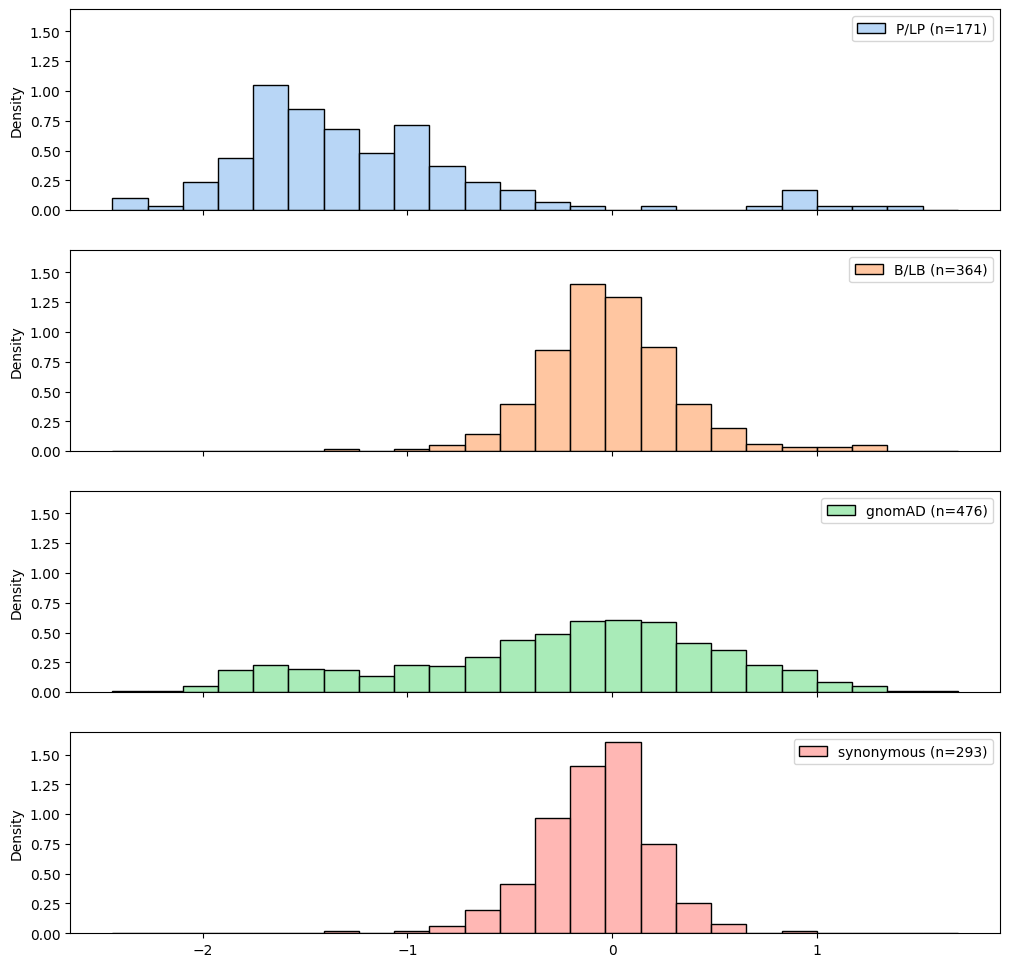

In [9]:
plotting.plot_samples({k : v.score.values for k,v in sample_data.items()})

In [10]:
pd.DataFrame.from_records([*[dict(sample_name='P/LP',score=score) for score in sample_data['P/LP'].score.values],
                            *[dict(sample_name='B/LB',score=score) for score in sample_data['B/LB'].score.values],
                            *[dict(sample_name='gnomAD',score=score) for score in sample_data['gnomAD'].score.values],
                            *[dict(sample_name='synonymous',score=score) for score in sample_data['synonymous'].score.values]]).to_csv(dataset_path / "samples.csv",index=False)